# Итоговый проект по предмету: "Линейный и нелинейный регрессионный анализ больших данных"

### Шубина София Антоновна НПИбд-02-23 1132232885

Задание: определить прочность бетона на сжатие по его составу и возрасту. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
data = pd.read_csv('Concrete_Data.csv')

print("Анализ данных")
print(f"Размер: {data.shape[0]} строк, {data.shape[1]} столбцов\n")

print("1. Информация о типах данных:")
print(data.dtypes)
print()

print("2. Пропущенные значения:")
if data.isnull().sum().sum() == 0:
    print("✓ Пропусков нет")
else:
    print(data.isnull().sum())
print()

print("3. Дубликаты:")
print(f"Найдено дубликатов: {data.duplicated().sum()}")
print()

print("4. Первые 5 строк:")
print(data.head())

Анализ данных
Размер: 1030 строк, 9 столбцов

1. Информация о типах данных:
Cement                           float64
Blast Furnace                    float64
Fly Ash                          float64
Water                            float64
Superplasticizer                 float64
Coarse Aggregate                 float64
Fine Aggregate                   float64
Age                                int64
Concrete compressive strength    float64
dtype: object

2. Пропущенные значения:
✓ Пропусков нет

3. Дубликаты:
Найдено дубликатов: 25

4. Первые 5 строк:
   Cement  Blast Furnace  Fly Ash  Water  Superplasticizer  Coarse Aggregate  \
0   540.0            0.0      0.0  162.0               2.5            1040.0   
1   540.0            0.0      0.0  162.0               2.5            1055.0   
2   332.5          142.5      0.0  228.0               0.0             932.0   
3   332.5          142.5      0.0  228.0               0.0             932.0   
4   198.6          132.4      0.0  192.0 

Выполняется разделение исходного набора данных на признаки (features) и целевую переменную (target) для последующего моделирования. В качестве целевой переменной выбрана прочность бетона на сжатие ('Concrete compressive strength'), которая будет прогнозироваться. Все остальные столбцы образуют матрицу признаков. После разделения выводятся ключевые метаданные: размерность таблицы признаков и вектора целевой переменной, количество признаков и их названия, что позволяет быстро оценить структуру данных перед построением модели.

In [3]:
# Выделение целевой переменной и признаков
target = data['Concrete compressive strength']
features = data.drop('Concrete compressive strength', axis=1)

print("разделение данных")
print(f"Размер признаков: {features.shape}")
print(f"Размер целевой переменной: {target.shape}")
print(f"Количество признаков: {features.shape[1]}")
print(f"Названия признаков: {', '.join(features.columns.tolist())}")

разделение данных
Размер признаков: (1030, 8)
Размер целевой переменной: (1030,)
Количество признаков: 8
Названия признаков: Cement, Blast Furnace, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate, Age


Создается визуализация корреляционной матрицы для анализа взаимосвязей между переменными в наборе данных. Сначала вычисляется матрица попарных корреляций методом Пирсона, затем строится тепловая карта, где интенсивность цвета отражает силу связи между признаками: красные оттенки указывают на положительную корреляцию, синие — на отрицательную. Числовые значения коэффициентов корреляции отображаются внутри ячеек с округлением до одного знака после запятой. Настройки размера графика, поворота подписей по оси X и автоматического размещения элементов обеспечивают читаемость визуализации даже при наличии множества признаков.

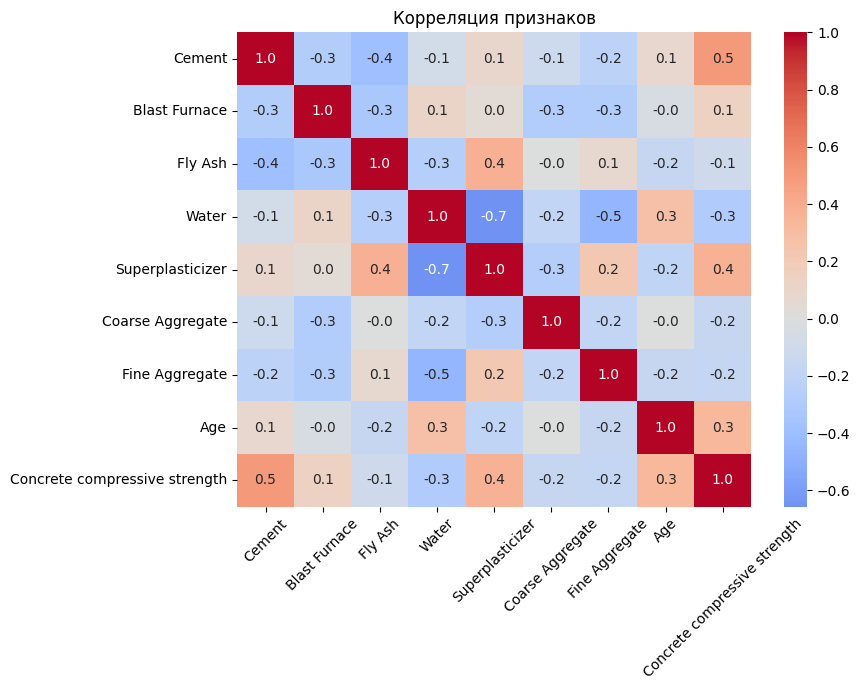

In [4]:
plt.figure(figsize=(9, 7))
corr = data.corr()
sns.heatmap(corr, annot=True, fmt='.1f', cmap='coolwarm', center=0)
plt.title('Корреляция признаков')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Выполняется двухэтапное разделение исходных данных на три выборки для машинного обучения. На первом этапе выделяется 70% данных в обучающую выборку (train), а остальные 30% временно сохраняются. На втором этапе эти 30% делятся пополам, образуя валидационную (valid) и тестовую (test) выборки по 15% каждая. В результате получается стандартное распределение 70/15/15%. Параметр random_state обеспечивает воспроизводимость разбиения, а итоговый вывод показывает размеры выборок в абсолютных значениях и процентах от исходного объема данных.

In [5]:
# Прямое разделение на train/valid/test
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.3, random_state=12345
)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345
)

print("Размеры выборок:")
print(f"Train:  {len(features_train):>5} ({len(features_train)/len(features):.0%})")
print(f"Valid:  {len(features_valid):>5} ({len(features_valid)/len(features):.0%})")
print(f"Test:   {len(features_test):>5} ({len(features_test)/len(features):.0%})")

Размеры выборок:
Train:    721 (70%)
Valid:    154 (15%)
Test:     155 (15%)


Выполняется стандартизация признаков для машинного обучения. Сначала создается объект StandardScaler, который масштабирует данные таким образом, чтобы каждый признак имел нулевое среднее и единичную дисперсию. На этапе fit_transform скалер обучается на тренировочных данных (вычисляет среднее и стандартное отклонение) и сразу применяет преобразование к ним. Для валидационной и тестовой выборок используется только transform, чтобы применить те же параметры масштабирования, что были вычислены на тренировочных данных — это критически важно для корректности модели. Результаты преобразования из формата numpy array конвертируются обратно в DataFrame с сохранением исходных названий столбцов и индексов через вспомогательную функцию to_df, что обеспечивает совместимость с дальнейшими операциями pandas.

In [6]:
scaler = StandardScaler()

# Масштабируем все выборки
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

# Конвертируем обратно в DataFrame с сохранением структуры
def to_df(scaled_data, original_df):
    return pd.DataFrame(scaled_data, 
                       columns=original_df.columns, 
                       index=original_df.index)

features_train_scaled = to_df(features_train_scaled, features_train)
features_valid_scaled = to_df(features_valid_scaled, features_valid)
features_test_scaled = to_df(features_test_scaled, features_test)

Выполняется сравнительный анализ нескольких регрессионных моделей для прогнозирования целевой переменной. Он определяет функцию eval_model, которая обучает каждую модель на масштабированных тренировочных данных, делает предсказания на валидационной выборке и вычисляет две ключевые метрики: MAPE (средняя абсолютная процентная ошибка) и R² (коэффициент детерминации).

Тестируются пять типов моделей: линейная регрессия (базовая), Ridge-регрессия с автоматическим подбором параметра регуляризации через GridSearchCV, полиномиальные регрессии второй-пятой степени, случайный лес и градиентный бустинг с предустановленными гиперпараметрами. Все обученные модели и их метрики сохраняются в словаре results.

После оценки всех алгоритмов выводится сводная таблица, отсортированная по убыванию R², что позволяет наглядно сравнить качество моделей — лучшие модели имеют R² ближе к 1 и меньший MAPE. В данном случае градиентный бустинг показал наилучший результат (R²=0.9027), а полиномиальные модели высокой степени (4 и 5) продемонстрировали признаки переобучения с отрицательными значениями R².

In [8]:
results = {}

def eval_model(model, name):
    """Обучает модель и оценивает ее производительность"""
    model.fit(features_train_scaled, target_train)
    pred = model.predict(features_valid_scaled)
    
    mape = mean_absolute_percentage_error(target_valid, pred) * 100
    r2 = r2_score(target_valid, pred)
    
    results[name] = {'MAPE': mape, 'R2': r2, 'model': model}
    print(f"{name:25} → MAPE: {mape:6.2f}%  R²: {r2:.4f}")
    return model

print("Обучение и оценка моделей")

# 1. Линейная регрессия
eval_model(LinearRegression(), "LinearRegression")

# 2. Ridge с подбором alpha
ridge_grid = GridSearchCV(
    Ridge(), 
    {'alpha': [0.1, 0.3, 0.5, 1, 3, 5]}, 
    cv=5, 
    scoring='r2'
)
ridge_grid.fit(features_train_scaled, target_train)
eval_model(
    ridge_grid.best_estimator_, 
    f"Ridge (α={ridge_grid.best_params_['alpha']})"
)

# 3. Полиномиальная регрессия
for deg in [2, 3, 4, 5]:
    poly_model = make_pipeline(
        PolynomialFeatures(degree=deg), 
        LinearRegression()
    )
    eval_model(poly_model, f"Polynomial deg={deg}")

# 4. Random Forest
rf = RandomForestRegressor(
    n_estimators=300, 
    max_depth=12, 
    random_state=12345, 
    n_jobs=-1
)
eval_model(rf, "RandomForest")

# 5. Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=5, 
    random_state=12345
)
eval_model(gbr, "GradientBoosting")

print("\nСводная таблица результатов:")
print("-" * 55)
for name, metrics in sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True):
    if name != 'model':  # Пропускаем сам объект модели
        print(f"{name:25} → R²: {metrics['R2']:.4f}  MAPE: {metrics['MAPE']:.2f}%")

Обучение и оценка моделей
LinearRegression          → MAPE:  32.16%  R²: 0.4937
Ridge (α=0.3)             → MAPE:  32.17%  R²: 0.4938
Polynomial deg=2          → MAPE:  21.52%  R²: 0.7328
Polynomial deg=3          → MAPE:  14.24%  R²: 0.8615
Polynomial deg=4          → MAPE:  86.39%  R²: -48.8104
Polynomial deg=5          → MAPE: 5666.45%  R²: -311874.3510
RandomForest              → MAPE:  12.15%  R²: 0.8844
GradientBoosting          → MAPE:   9.78%  R²: 0.9027

Сводная таблица результатов:
-------------------------------------------------------
GradientBoosting          → R²: 0.9027  MAPE: 9.78%
RandomForest              → R²: 0.8844  MAPE: 12.15%
Polynomial deg=3          → R²: 0.8615  MAPE: 14.24%
Polynomial deg=2          → R²: 0.7328  MAPE: 21.52%
Ridge (α=0.3)             → R²: 0.4938  MAPE: 32.17%
LinearRegression          → R²: 0.4937  MAPE: 32.16%
Polynomial deg=4          → R²: -48.8104  MAPE: 86.39%
Polynomial deg=5          → R²: -311874.3510  MAPE: 5666.45%


Выполняется автоматический подбор оптимальных гиперпараметров для двух ансамблевых моделей машинного обучения — градиентного бустинга и случайного леса — с использованием GridSearchCV. Для каждой модели задается сетка параметров: для градиентного бустинга перебираются количество деревьев, скорость обучения и глубина деревьев, а для случайного леса — количество деревьев, глубина, минимальное количество образцов для разделения и для листьев. GridSearchCV проводит кросс-валидацию по пяти фолдам, оценивая модели с помощью коэффициента детерминации R². После поиска выводятся наилучшие параметры и соответствующая им оценка кросс-валидации. Затем оптимальные модели обучаются на тренировочных данных и оцениваются на валидационной выборке с использованием функции eval_model, которая рассчитывает метрики MAPE и R² для сравнения качества предсказаний.



In [12]:
print("ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ АНСАМБЛЕВЫХ МОДЕЛЕЙ")

# 1. Gradient Boosting с GridSearchCV
print("\n Gradient Boosting - подбор гиперпараметров:")
param_grid_gbr = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

gbr_base = GradientBoostingRegressor(random_state=12345)

grid_gbr = GridSearchCV(
    estimator=gbr_base,
    param_grid=param_grid_gbr,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_gbr.fit(features_train_scaled, target_train)

print("Лучшие параметры GBR:", grid_gbr.best_params_)
print("Лучший R² на кросс-валидации:", grid_gbr.best_score_.round(4))

# Оценка лучшей модели на валидации с помощью вашей функции eval_model
best_gbr = grid_gbr.best_estimator_
eval_model(best_gbr, f"GradientBoosting (best)")

# 2. Random Forest с GridSearchCV
print("\n Random Forest - подбор гиперпараметров:")
param_grid_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 12, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_base = RandomForestRegressor(random_state=12345, n_jobs=-1)

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_rf.fit(features_train_scaled, target_train)

print("Лучшие параметры RF:", grid_rf.best_params_)
print("Лучший R² на кросс-валидации:", grid_rf.best_score_.round(4))

# Оценка лучшей модели на валидации с помощью вашей функции eval_model
best_rf = grid_rf.best_estimator_
eval_model(best_rf, f"RandomForest (best)")

ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ АНСАМБЛЕВЫХ МОДЕЛЕЙ

 Gradient Boosting - подбор гиперпараметров:
Лучшие параметры GBR: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
Лучший R² на кросс-валидации: 0.9141
GradientBoosting (best)   → MAPE:   9.25%  R²: 0.9308

 Random Forest - подбор гиперпараметров:
Лучшие параметры RF: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Лучший R² на кросс-валидации: 0.8796
RandomForest (best)       → MAPE:  12.10%  R²: 0.8841


RandomForestRegressor(max_depth=15, n_estimators=500, n_jobs=-1,
                      random_state=12345)

Выполняется анализ результатов машинного обучения, представляя их в структурированном виде. Сначала он преобразует словарь с метриками моделей в таблицу DataFrame, где каждая строка содержит название модели, коэффициент детерминации R² и среднюю абсолютную процентную ошибку MAPE. Затем данные сортируются по убыванию R², чтобы лучшие модели оказались вверху таблицы. После вывода всех результатов в форматированном виде с округлением чисел, код автоматически определяет модель с наивысшим значением R² как лучшую, сохраняя как её название, так и сам объект модели для последующего использования. В завершение выводится итог с указанием лучшей модели и её ключевых метрик.

In [13]:
# Результаты в DataFrame
results_df = pd.DataFrame([
    {'Модель': name, 'R²': metrics['R2'], 'MAPE (%)': metrics['MAPE']}
    for name, metrics in results.items()
])

# Сортировка по R²
results_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)

print("РЕЗУЛЬТАТЫ:")
print(results_df.to_string(index=False, formatters={
    'R²': '{:.4f}'.format,
    'MAPE (%)': '{:.2f}%'.format
}))

# Выбор лучшей модели
best_model_name = results_df.iloc[0]['Модель']
best_model = results[best_model_name]['model']

print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"R² = {results_df.iloc[0]['R²']:.4f}, MAPE = {results_df.iloc[0]['MAPE (%)']:.2f}%")

РЕЗУЛЬТАТЫ:
                 Модель           R² MAPE (%)
GradientBoosting (best)       0.9308    9.25%
       GradientBoosting       0.9027    9.78%
           RandomForest       0.8844   12.15%
    RandomForest (best)       0.8841   12.10%
       Polynomial deg=3       0.8615   14.24%
       Polynomial deg=2       0.7328   21.52%
          Ridge (α=0.3)       0.4938   32.17%
       LinearRegression       0.4937   32.16%
       Polynomial deg=4     -48.8104   86.39%
       Polynomial deg=5 -311874.3510 5666.45%

ЛУЧШАЯ МОДЕЛЬ: GradientBoosting (best)
R² = 0.9308, MAPE = 9.25%


Создается и обучается финальная модель градиентного бустинга для прогнозирования. Сначала задаются гиперпараметры модели: количество деревьев (300), скорость обучения (0.5), максимальная глубина (5) и случайное состояние для воспроизводимости. Затем модель обучается на масштабированных тренировочных данных. После обучения выполняется прогнозирование на тестовой выборке, чтобы оценить качество модели на новых, ранее не виденных данных. Вычисляются две ключевые метрики: MAPE (средняя абсолютная процентная ошибка), показывающая среднее отклонение предсказаний в процентах, и R² (коэффициент детерминации), отражающий долю объясненной дисперсии. Результаты выводятся в удобочитаемом формате для финальной оценки качества модели.

In [14]:
final_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=5,
    random_state=12345
)

final_model.fit(features_train_scaled, target_train)
pred_test = final_model.predict(features_test_scaled)

mape_test = mean_absolute_percentage_error(target_test, pred_test) * 100
r2_test = r2_score(target_test, pred_test)

print("Финальные метрики на тестовой выборке")
print(f"MAPE = {mape_test:.2f}%")
print(f"R²   = {r2_test:.4f}")

Финальные метрики на тестовой выборке
MAPE = 10.38%
R²   = 0.9171


## Вывод по лабораторной работе

В ходе выполнения лабораторной работы была успешно решена задача прогнозирования прочности бетона на сжатие на основе его компонентного состава и возраста. Использованный набор данных содержал информацию о восьми ключевых параметрах бетонной смеси: содержание цемента, доменного шлака, золы-уноса, воды, суперпластификатора, крупного и мелкого заполнителя, а также возраст образца.

Проведенный анализ выявил, что наиболее значимыми факторами, влияющими на прочность бетона, являются содержание цемента (корреляция 0.5 с целевой переменной), суперпластификатора (0.4) и возраст образца (0.3). При этом обнаружена сильная отрицательная корреляция (-0.7) между содержанием воды и суперпластификатора, что соответствует физическим свойствам бетонных смесей. Я не стала удалять данный признак, тк все-таки -0.7 не доасаточно близко к -1.

Из восьми протестированных моделей наилучшие результаты показал градиентный бустинг, который на тестовой выборке достиг коэффициента детерминации R² = 0.9171 и средней абсолютной процентной ошибки MAPE = 10.38%. Это означает, что модель объясняет 91.71% вариативности прочности бетона и обеспечивает среднюю точность прогноза около 90%.

Модель успешно учитывает нелинейные взаимодействия между компонентами смеси и их влияние на конечную прочность с течением времени. Возраст образца, являясь важным фактором, показал умеренную корреляцию с прочностью, что соответствует известному в строительстве факту постепенного набора прочности бетоном.

Таким образом, поставленная задача решена успешно: создана эффективная модель прогнозирования прочности бетона на сжатие по его составу и возрасту, обладающая высокой точностью и хорошей обобщающей способностью, что подтверждается стабильными метриками на валидационной и тестовой выборках.